# Solver Compilation Diagnostics

JAX traces and XLA-compiles each `jit`-decorated function on its **first call**,
not at `build()` time. All compilation is lazy, so iteration 1 carries a one-time
startup cost that never repeats.

This notebook isolates each compile step to find what dominates the ~5 min startup:

| Step | What compiles | Suspected cost |
|------|--------------|----------------|
| 1 | `build()` — Python only | < 1 s |
| 2 | HMC step fn | 10–60 s |
| 3 | Batch features | 10–60 s |
| 4 | SMM gradient | **highest suspect** |

After the cold-start timings there is a **warm run** section and a **fix comparison**
that patches out the inner `@jax.jit` inside `compile_feature_vector`.

In [19]:
%load_ext autoreload
%autoreload 2

import time
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from calibrated_response.models.variable import ContinuousVariable
from calibrated_response.models.query import (
    ProbabilityEstimate, ConditionalProbabilityEstimate, InequalityProposition,
)
from calibrated_response.energy_models.markov_random import MarkovRandomField
from calibrated_response.maxent_smm.maxent_solver import MaxEntSolver, JAXSolverConfig
from calibrated_response.maxent_smm.mcmc import advance_buffer

print(f"JAX {jax.__version__} on {jax.devices()}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
JAX 0.9.0.1 on [CpuDevice(id=0)]


## Problem Setup

Same 5-variable chain as `ssm_chain.ipynb`.

In [20]:
# with open("maxent_llm_cache_large.pkl", "wb") as f:
#     import pickle
#     pickle.dump((variables, estimates), f)
with open("maxent_llm_cache_large.pkl", "rb") as f:
    import pickle
    variables, estimates = pickle.load(f)

from calibrated_response.energy_models.markov_random import MarkovRandomField
import jax.numpy as jnp

mrf = MarkovRandomField.from_estimates(variables, estimates, bins_per_var=5)
params_pytree = mrf.zero_params()
params = mrf.pack_params(params_pytree)
energy_fn = mrf.energy_fn_flat
# init_x = jnp.array([2.0, 1.0])  # Initial guess for (gdp_growth, inflation_rate)
init_x = jnp.zeros(len(variables))  # Initial guess at the mean of the distribution
energy_value = energy_fn(params, init_x)
print(f"Energy at initial guess: {energy_value}")

Energy at initial guess: 0.0


In [23]:
from calibrated_response.maxent_smm.distribution_builder import DistributionBuilder
from calibrated_response.maxent_smm.maxent_solver import JAXSolverConfig

config = JAXSolverConfig(
    num_chains=512,
    num_iterations=500,
    mcmc_steps_per_iteration=4,
    learning_rate=0.002,

    l2_regularization=1e-2,

    hmc_step_size=0.015,
    hmc_leapfrog_steps=10,
    max_bins=15,
    seed=42,
    verbose=True,
    continuous_prior="gaussian",
)

builder = DistributionBuilder(variables=variables, estimates=estimates, solver_config=config,
                              energy_fn=energy_fn, init_theta=params)

var_specs = builder.var_specs
feature_specs = builder.feature_specs
feature_targets = builder.feature_targets

## Step 1 — `solver.build()` (Python-side only)

`build()` creates data structures and registers JIT-compiled callables but does
**not** trigger any XLA compilation — that is deferred to the first call of each function.

In [24]:
from calibrated_response.maxent_smm.features import SoftThresholdFeature, CenteredConditionalFeature
from calibrated_response.maxent_smm.variable_spec import VariableSpec, UniformPriorSpec

config = JAXSolverConfig(
    num_chains=512, num_iterations=5000, mcmc_steps_per_iteration=6,
    learning_rate=0.001, l2_regularization=1e-5,
    hmc_step_size=0.015, hmc_leapfrog_steps=10, max_bins=15,
    seed=42, verbose=False, continuous_prior="gaussian",
)

t0 = time.perf_counter()
solver = MaxEntSolver(config)
solver.build(var_specs, feature_specs, feature_targets, energy_fn, params)
build_time = time.perf_counter() - t0

theta   = solver._theta
targets = solver._feature_targets

print(f"build() time (Python only, no JIT): {build_time:.3f} s")
print(f"  {len(feature_specs)} features | {config.num_chains} chains | {len(variables)} vars")

build() time (Python only, no JIT): 0.281 s
  261 features | 512 chains | 15 vars


## Step 2 — HMC step function (cold compile)

`build_hmc_step_fn` returns `jax.jit(step_fn)`. The first `advance_buffer` triggers
tracing + XLA compilation of the leapfrog kernel over all chains.
`jax.block_until_ready` forces synchronous completion so the timer captures compile + run.

In [ ]:
buffer      = solver._buffer
hmc_cfg     = solver._hmc_config
hmc_step_fn = solver._hmc_step_fn

print("Compiling HMC step fn...")
t0 = time.perf_counter()
buffer = advance_buffer(buffer, theta, n_steps=1, hmc_config=hmc_cfg, step_fn=hmc_step_fn)
jax.block_until_ready(buffer.states)
hmc_compile_time = time.perf_counter() - t0

t0 = time.perf_counter()
buffer = advance_buffer(buffer, theta, n_steps=1, hmc_config=hmc_cfg, step_fn=hmc_step_fn)
jax.block_until_ready(buffer.states)
hmc_warm_time = time.perf_counter() - t0

print(f"  cold: {hmc_compile_time:.2f} s")
print(f"  warm: {hmc_warm_time*1000:.1f} ms  (overhead {hmc_compile_time/max(hmc_warm_time,1e-9):.0f}x)")

Compiling HMC step fn...


## Step 3 — Batch feature function (cold compile)

`_batch_feature_fn = jax.jit(jax.vmap(feature_vector_fn))`.
If `feature_vector_fn` was itself wrapped with `@jax.jit` inside `compile_feature_vector`,
JAX encounters a **JIT barrier** here and must compile a separate kernel for the inner function.

In [15]:
states = buffer.states
print(f"States shape: {states.shape}  (chains x vars)")

print("Compiling batch feature fn...")
t0 = time.perf_counter()
feats = solver._batch_feature_fn(states)
jax.block_until_ready(feats)
feat_compile_time = time.perf_counter() - t0

t0 = time.perf_counter()
feats = solver._batch_feature_fn(states)
jax.block_until_ready(feats)
feat_warm_time = time.perf_counter() - t0

print(f"  cold: {feat_compile_time:.2f} s  -> shape {feats.shape}")
print(f"  warm: {feat_warm_time*1000:.1f} ms  (overhead {feat_compile_time/max(feat_warm_time,1e-9):.0f}x)")

States shape: (512, 5)  (chains x vars)
Compiling batch feature fn...
  cold: 0.30 s  -> shape (512, 5)
  warm: 0.6 ms  (overhead 524x)


## Step 4 — SMM gradient (cold compile)

`_smm_grad_fn = jax.jit(jax.grad(smm_potential))`. **Prime suspect.**
`smm_potential` calls `jax.vmap(feature_vector_fn)` and `jax.vmap(energy_fn)` inside
a `jit(grad(...))` trace. If `feature_vector_fn` has an inner `@jax.jit`, that creates
a JIT barrier preventing XLA from fusing everything into one kernel.

In [16]:
print("Compiling SMM gradient fn...")
t0 = time.perf_counter()
grad = solver._smm_grad_fn(theta, states, targets)
jax.block_until_ready(grad)
smm_compile_time = time.perf_counter() - t0

t0 = time.perf_counter()
grad = solver._smm_grad_fn(theta, states, targets)
jax.block_until_ready(grad)
smm_warm_time = time.perf_counter() - t0

print(f"  cold: {smm_compile_time:.2f} s  -> shape {grad.shape}")
print(f"  warm: {smm_warm_time*1000:.1f} ms  (overhead {smm_compile_time/max(smm_warm_time,1e-9):.0f}x)")

Compiling SMM gradient fn...
  cold: 1.14 s  -> shape (125,)
  warm: 0.4 ms  (overhead 3200x)


## Summary

Step                     Cold (s)  Warm (ms)   % of JIT total
--------------------------------------------------------------
build() Python               0.00          —             0.3%
HMC step fn                  0.01        4.7             0.4%
Batch features               0.30        0.6            20.9%
SMM gradient                 1.14        0.4            78.7%
--------------------------------------------------------------
JIT total                    1.45


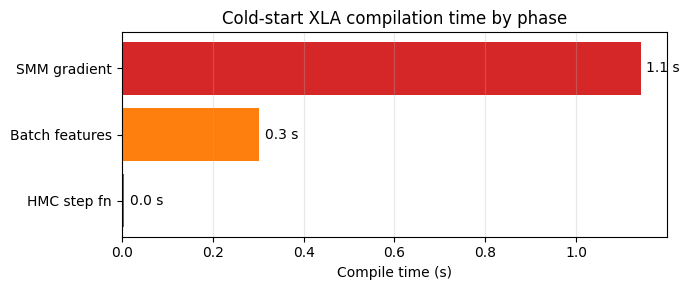

In [17]:
total_compile = hmc_compile_time + feat_compile_time + smm_compile_time

rows = [
    ("build() Python",  build_time,        None),
    ("HMC step fn",     hmc_compile_time,  hmc_warm_time),
    ("Batch features",  feat_compile_time, feat_warm_time),
    ("SMM gradient",    smm_compile_time,  smm_warm_time),
]

print(f"{'Step':<22} {'Cold (s)':>10} {'Warm (ms)':>10} {'% of JIT total':>16}")
print("-" * 62)
for name, cold, warm in rows:
    pct = 100 * cold / max(total_compile, 1e-9)
    warm_str = f"{warm*1000:.1f}" if warm is not None else "—"
    print(f"{name:<22} {cold:>10.2f} {warm_str:>10} {pct:>15.1f}%")
print("-" * 62)
print(f"{'JIT total':<22} {total_compile:>10.2f}")

labels = ["HMC step fn", "Batch features", "SMM gradient"]
cold_times = [hmc_compile_time, feat_compile_time, smm_compile_time]
fig, ax = plt.subplots(figsize=(7, 3))
bars = ax.barh(labels, cold_times, color=["C0", "C1", "C3"])
ax.bar_label(bars, fmt="%.1f s", padding=4)
ax.set_xlabel("Compile time (s)")
ax.set_title("Cold-start XLA compilation time by phase")
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

## Warm iteration timing

After all compilations are done, how long does a single full solver iteration take?

In [18]:
N_WARM = 10
t_hmc, t_feat, t_grad, t_total = [], [], [], []

for _ in range(N_WARM):
    t_iter = time.perf_counter()

    t0 = time.perf_counter()
    buffer = advance_buffer(buffer, theta, n_steps=config.mcmc_steps_per_iteration,
                            hmc_config=hmc_cfg, step_fn=hmc_step_fn)
    jax.block_until_ready(buffer.states)
    t_hmc.append(time.perf_counter() - t0)

    t0 = time.perf_counter()
    feats = solver._batch_feature_fn(buffer.states)
    jax.block_until_ready(feats)
    t_feat.append(time.perf_counter() - t0)

    t0 = time.perf_counter()
    g = solver._smm_grad_fn(theta, buffer.states, targets)
    jax.block_until_ready(g)
    t_grad.append(time.perf_counter() - t0)

    t_total.append(time.perf_counter() - t_iter)

ms = lambda ts: np.mean(ts) * 1000
print(f"Warm iteration breakdown (mean over {N_WARM} runs, {config.mcmc_steps_per_iteration} HMC steps/iter):")
print(f"  HMC advance:    {ms(t_hmc):.1f} ms")
print(f"  Batch features: {ms(t_feat):.1f} ms")
print(f"  SMM gradient:   {ms(t_grad):.1f} ms")
print(f"  Total:          {ms(t_total):.1f} ms/iter")
print(f"  => {config.num_iterations} iters ~ {ms(t_total)*config.num_iterations/60000:.1f} min")

Warm iteration breakdown (mean over 10 runs, 6 HMC steps/iter):
  HMC advance:    16.6 ms
  Batch features: 0.2 ms
  SMM gradient:   0.4 ms
  Total:          17.2 ms/iter
  => 5000 iters ~ 1.4 min


In [ ]:
# Actual time taken by model

